In [2]:
import os,re
import requests as rq
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy

In [3]:
data = rq.get("https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=List_of_hip_hop_musicians").json()
list_markup = data["query"]["pages"]["140853"]["revisions"][0]["*"]
link_regex = r"\* \[\[(.+?)[\(\]]"

rappers = re.findall(link_regex, list_markup)

In [4]:
with open("rappers.txt", 'w') as f:
    for r in rappers:
        f.write(r.encode('utf-8') + "\n")

In [47]:
import spotipy.oauth2 as oauth2

# When an error occurs saying the token expired, re-run this cell.
# Tokens are 1 hour I think.
client_id = 'e3344de9f0454df280cc34cdba040bf7'
client_secret = 'da09e980b2fb4f11a68a3c00a2669a7d'

credentials = oauth2.SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

In [6]:
def get_albums(rapper):
    results = spotify.search(q='artist:%s' % rapper,type='artist')
    
    artist_id = results['artists']['items'][0]['uri']
    
    albums = spotify.artist_albums(artist_id)
    
    # For some reason duplicates some albums. Wrap as a set
    return set([album['name'] for album in albums['items']])

In [7]:
def get_album_artists(album_name):
    results = spotify.search(q='album:%s' % album_name,type='album')
    
    album_id = results['albums']['items'][0]['uri']
    
    tracks = spotify.album_tracks(album_id)
    return set([artist['name']  
            for track in tracks['items']
            for artist in track['artists']])

In [8]:
def get_collaborators(rapper):
    """Returns a dictionary of album:artists entry"""
    
    albums = get_albums(rapper)
    
    return {album:list(get_album_artists(album)) for album in albums}

In [40]:
try:
    a = get_collaborators("2 Chainz")
except IndexError:
    print "FAILED"

FAILED


Do rappers that fail just not have any collaborators?

In [31]:
q = list([item for sublist in a.values() for item in sublist])

In [32]:
col_dict = {}
for i in q: 
    if i not in col_dict: 
        col_dict[i] =  1
    else: 
        col_dict[i] += 1

In [33]:
col_dict

{u'03 Greedo': 15,
 u'AD': 1,
 u'ALLBLACK': 2,
 u'Bambino': 1,
 u'Bizz Turn Meup': 1,
 u'Blacowt': 1,
 u"Chris O'Bannon": 1,
 u'Cig Droopy': 1,
 u'D-Lo': 1,
 u'Doley Bernays': 1,
 u'FKi 1st': 1,
 u'Filthy Pac': 1,
 u'G Perico': 1,
 u'Good Gas': 1,
 u'Hot Dollar': 1,
 u'Iamsu!': 1,
 u'Johnny Boy Duece': 1,
 u'Joy Division': 1,
 u'KAYTRANADA': 1,
 u'KEY': 2,
 u'Kash Doll': 1,
 u'Ketchy the Great': 1,
 u'Lamontwrld': 1,
 u'Lars Jansson Trio': 1,
 u'Lil One Hunnet': 1,
 u'Lil Uzi Vert': 1,
 u'Lil Yee': 1,
 u'MadeinTYO': 1,
 u'Mal & Quill': 1,
 u'ManMan Savage': 1,
 u'Mike Finesse': 1,
 u'Nef The Pharaoh': 2,
 u'Nemz': 1,
 u'NerdOut': 1,
 u'OMB Peezy': 2,
 u'PnB Rock': 1,
 u'Primer Dia': 1,
 u'Ralfy the Plug': 1,
 u'Rappa': 1,
 u'Rich The Kid': 2,
 u'Rome Fortune': 1,
 u'Runway Richy': 1,
 u'Sango': 1,
 u'Sigurdur Flosason': 1,
 u'Sleepy': 1,
 u'Smooky MarGielaa': 1,
 u'Steve Petrunak': 1,
 u'T.$poon': 1,
 u'TNT Tez': 1,
 u'Telli': 1,
 u'Toro y Moi': 1,
 u'UnoTheActivist': 1,
 u'Wolfgang Ga

In [40]:
rappers = set()

with open("rappers.txt", "r") as f: 
    for r in f:
        rappers.add(r)
        

In [53]:
collaboration_network = nx.Graph()

for r in list(rappers)[:100]:
    print 'Processing rapper:', r
    try:
        #gets collaborators by album
        c_by_a = get_collaborators(r)
        #sorts collaborators into one list
        collaborators = list([item for sublist in c_by_a.values() for item in sublist])
        
        #creating a dictionary from the collaborators to count the number of collaborations for weighted edges
        col_dict = {}
        for c in collaborators:
            #don't include self as a rapper
            if c == r: 
                continue
            #add new collaborators to the dict with a count of 1
            if c not in col_dict: 
                col_dict[c] =  1
            #add one to the count of previous collaborators
            else: 
                col_dict[c] += 1

    except IndexError:
        print 'Error for:', r
        continue
        
    
    for c in set(collaborators):
        #don't include self as a collaborator
        if c == r: 
            continue
        else:
            #get the weight for the edge as number of collaborations from dict
            w = col_dict[c]
            #add the weighted edges
            collaboration_network.add_edge(r,c,weight=w)

            if collaboration_network.degree(c) == 1 and w == 1:
                collaboration_network.remove_node(c)

Processing rapper: 03 Greedo
Processing rapper: 100 Kila
Processing rapper: 100s 
Processing rapper: 12 Gauge 
Error for: 12 Gauge 
Processing rapper: 2 Chainz
Error for: 2 Chainz
Processing rapper: 2 Pistols
Processing rapper: Fabo|2$ Fabo
Error for: Fabo|2$ Fabo
Processing rapper: 21 Savage
Error for: 21 Savage
Processing rapper: 2Mex
Error for: 2Mex
Processing rapper: 360 
Processing rapper: 40 Glocc
Processing rapper: 50 Cent
Error for: 50 Cent
Processing rapper: 6ix9ine
Processing rapper: 6lack
Error for: 6lack
Processing rapper: The 6th Letter
Processing rapper: 9th Wonder
Error for: 9th Wonder
Processing rapper: A+ 
Processing rapper: A-Q
Processing rapper: Ab-Soul
Error for: Ab-Soul
Processing rapper: A Boogie wit da Hoodie
Error for: A Boogie wit da Hoodie
Processing rapper: Abstract Rude
Processing rapper: Ace Hood
Error for: Ace Hood
Processing rapper: Aceyalone


KeyboardInterrupt: 

In [43]:
import json

In [55]:
with open('rappers_network.json', 'w') as fp:
    json.dump(nx.node_link_data(collaboration_network), fp)

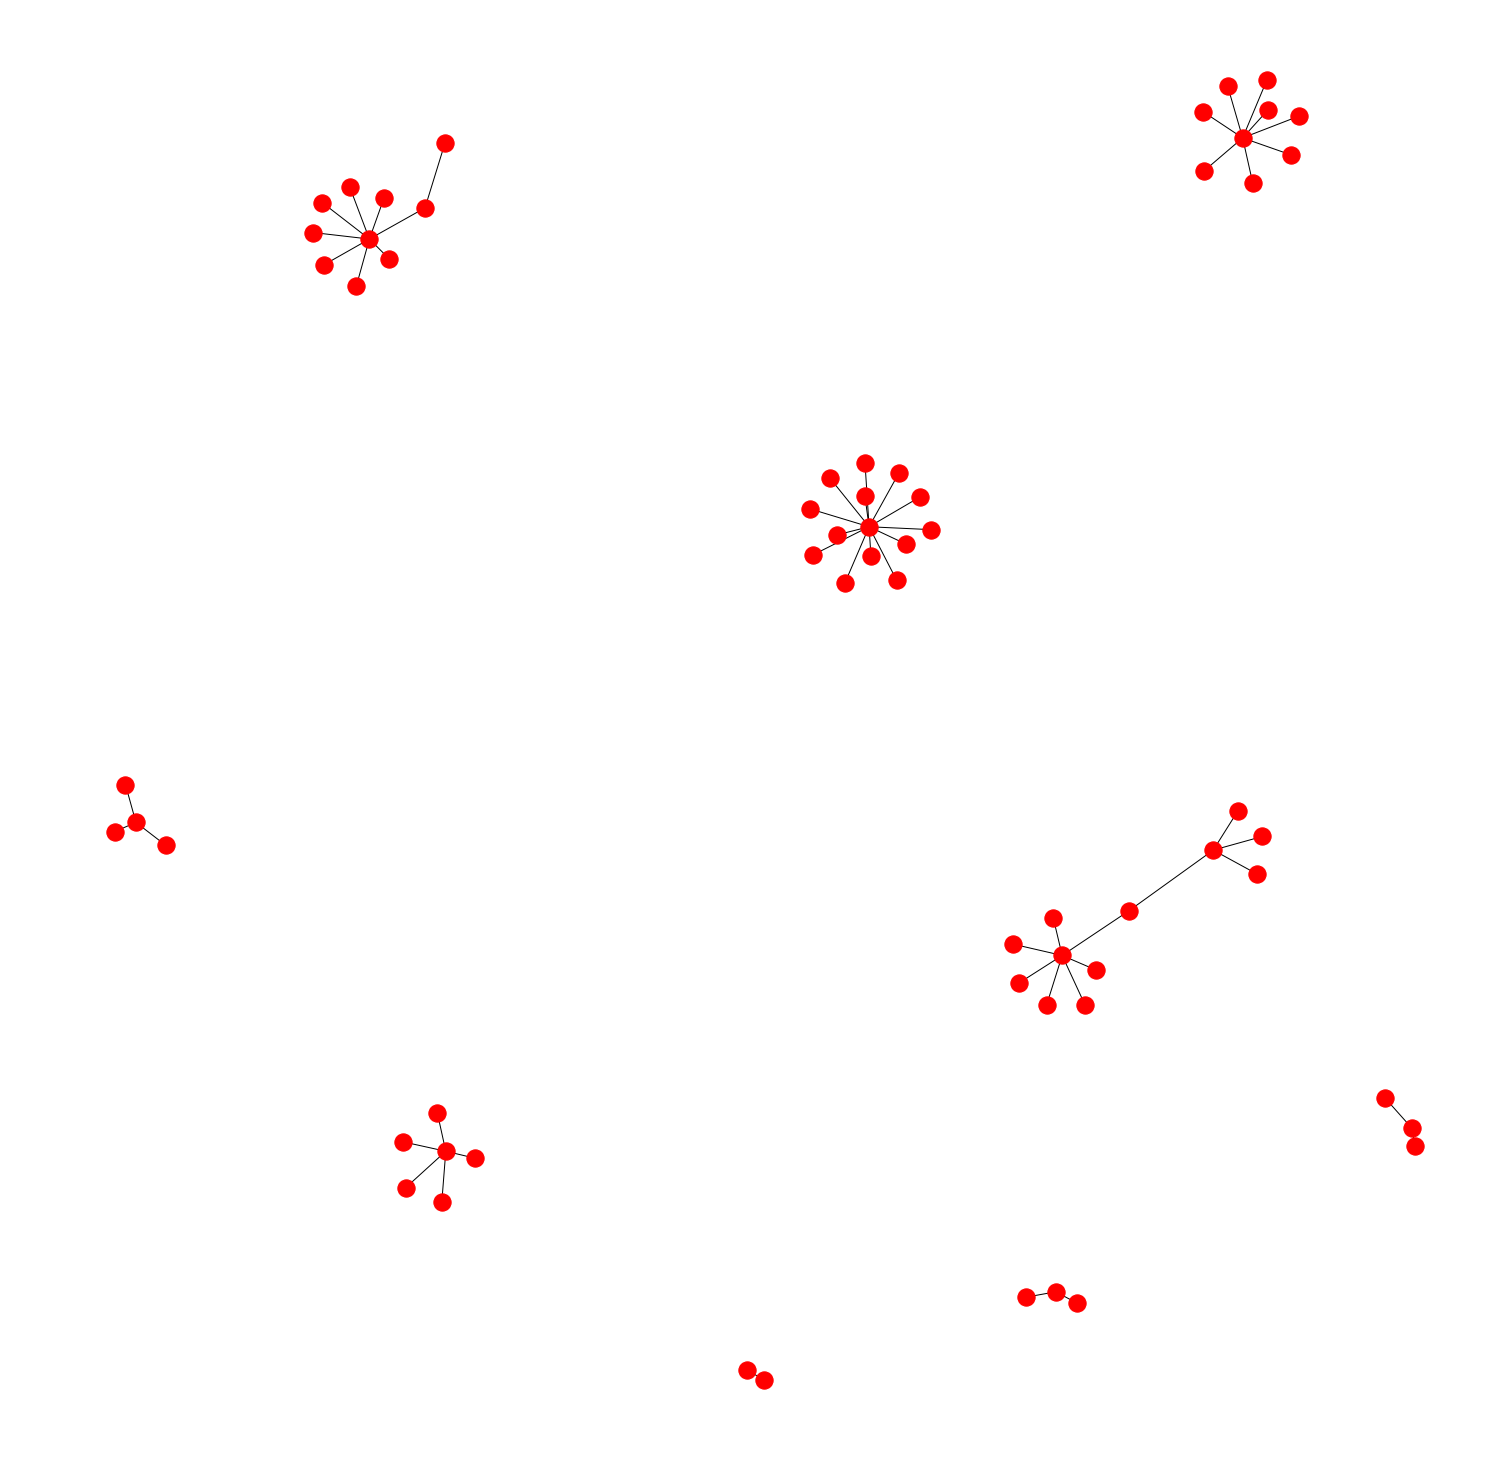

In [54]:
plt.figure(figsize=[20,20])
nx.draw(collaboration_network)
plt.show()